In [2]:
import ncdata

In [3]:
import stratify

In [4]:
import iris
import numpy as np
import xarray as xr

In [5]:
from pathlib import Path

In [6]:
import matplotlib.pyplot as plt
import iris.quickplot as qplt

In [7]:
iris.FUTURE.date_microseconds = True

In [8]:
esm_grid_mask_filepath = Path('/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/grids/global.N96/2020.05.19/qrparm.mask')

In [9]:
grid_cube = iris.load_cube(esm_grid_mask_filepath)
grid_cube.coord("latitude").guess_bounds()
grid_cube.coord("longitude").guess_bounds()

In [10]:
grid_cube

<iris 'Cube' of land_binary_mask / (1) (latitude: 145; longitude: 192)>

In [11]:
lat_points = grid_cube.coord("latitude").points
lon_points = grid_cube.coord("longitude").points

In [12]:
grid_coords = [("latitude", lat_points), ("longitude", lon_points)]

In [13]:
cmip6_pi_ozone_filepath = Path('/g/data/qv56/replicas/input4MIPs/CMIP6/CMIP/UReading/UReading-CCMI-1-0/atmos/monC/vmro3/gn/v20160830/vmro3_input4MIPs_ozone_CMIP_UReading-CCMI-1-0_gn_185001-185012.nc')

In [14]:
cmip6_pi_ozone_cube = iris.load_cube(cmip6_pi_ozone_filepath)

In [39]:
cmip6_pi_ozone_cube.coords()[0].__dict__

{'_metadata_manager': MetadataManager(standard_name='time', long_name='time', var_name='time', units=Unit('months since 1850-01-01 00:00', calendar='standard'), attributes={}, coord_system=None, climatological=False, circular=False),
 '_values_dm': DataManager(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5])),
 '_bounds_dm': DataManager(array([[ 0.,  1.],
        [ 1.,  2.],
        [ 2.,  3.],
        [ 3.,  4.],
        [ 4.,  5.],
        [ 5.,  6.],
        [ 6.,  7.],
        [ 7.,  8.],
        [ 8.,  9.],
        [ 9., 10.],
        [10., 11.],
        [11., 12.]])),
 '_ignore_axis': False}

In [13]:
cmip6_interp = cmip6_pi_ozone_cube.interpolate(grid_coords, iris.analysis.Linear())

In [52]:
months_since_1850_units = cf_units.Unit('months since 1850-01-01 00:00', calendar='360_day')

In [55]:
cmip6_interp.coord('time').units

Unit('months since 1850-01-01 00:00', calendar='standard')

In [56]:
cmip6_interp.coord('time').points

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5])

In [60]:
help(cmip6_interp.coord_dims)

Help on method coord_dims in module iris.cube:

coord_dims(coord: 'str | DimCoord | AuxCoord | AuxCoordFactory') -> 'tuple[int, ...]' method of iris.cube.Cube instance
    Return a tuple of the data dimensions relevant to the given coordinate.
    
    When searching for the given coordinate in the cube the comparison is
    made using coordinate metadata equality. Hence the given coordinate
    instance need not exist on the cube, and may contain different
    coordinate values.
    
    Parameters
    ----------
    coord :
        The (name of the) coord to look for.
    
    Returns
    -------
    tuple:
         A tuple of the data dimensions relevant to the given coordinate.



In [63]:
time_coord_dim = cmip6_interp.coord_dims('time')

In [64]:
time_coord_dim

(0,)

In [57]:
new_time_coord = iris.coords.DimCoord(
    cmip6_interp.coord('time').points,
    standard_name='time',
    units=months_since_1850_units
)

In [65]:
cmip6_interp.remove_coord('time')
cmip6_interp.add_dim_coord(new_time_coord, time_coord_dim)

In [66]:
cmip6_interp

<iris 'Cube' of mole_fraction_of_ozone_in_air / (mole mole-1) (time: 12; air_pressure: 66; latitude: 145; longitude: 192)>

In [107]:
cmip6_interp.coord('time').points

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5])

In [117]:
feb=cftime.Datetime360Day(1850, 2, 1)

In [118]:
jan=iris.Constraint(time=lambda cell: cell.point < feb)

In [119]:
cmip6_interp_jan = cmip6_interp.extract(jan)

In [121]:
cmip6_interp_jan

<iris 'Cube' of mole_fraction_of_ozone_in_air / (mole mole-1) (air_pressure: 66; latitude: 145; longitude: 192)>

In [122]:
cmip6_interp_jan.coord('time').units

Unit('months since 1850-01-01 00:00', calendar='360_day')

In [68]:
import cf_units
import cftime

In [69]:
iris.FUTURE.save_split_attrs = True

In [156]:
from ncdata.iris_xarray import cubes_to_xarray, cubes_from_xarray

In [123]:
cmip6_interp_xr = cubes_to_xarray(cmip6_interp_jan)

In [124]:
cmip6_interp_xr

<xarray.Dataset> Size: 7MB
Dimensions:  (plev: 66, lat: 145, lon: 192)
Coordinates:
  * plev     (plev) float32 264B 1e+03 925.0 850.0 ... 0.0005 0.0003 0.0001
  * lat      (lat) float32 580B -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float32 768B 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    time     object 8B dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    vmro3    (plev, lat, lon) float32 7MB dask.array<chunksize=(66, 145, 192), meta=numpy.ma.core.MaskedArray>
Attributes: (12/24)
    Conventions:             CF-1.7
    activity_id:             input4MIPs
    comment:                 Merged data product using WACCM (WACCM1-CESM CCM...
    contact:                 Michaela Hegglin (m.i.hegglin@reading.ac.uk)
    creation_date:           2016-08-30T12:00:00Z
    dataset_category:        ozone
    ...                      ...
    source:                  CCMI v1.0: merged ozone using WACCM and CMAM ozo...
    source_id:               UReading-CCMI-1-0
    target_mip:              CMIP
    title:                   CCMI v1.0 dataset prepared for input4MIPs
    tracking_id:             hdl:21.14100/5f5b44e0-e809-4db2-bd88-8a0fc4ad4128
    variable_id:             vmro3

In [125]:
ozone_ds = cmip6_interp_xr.rename({'plev': 'pressure'})

In [126]:
spinup_filepath = Path('/g/data/p73/archive/CMIP7/ACCESS-ESM1-6/spinup/June2025/output999/atmosphere/netCDF/aiihca.pa-209112_mon.nc')

In [127]:
spinup_cube = iris.load(spinup_filepath)

In [128]:
pressure_index = 94

In [129]:
pressure_cube=spinup_cube[pressure_index]

In [142]:
pressure_cube=pressure_cube.collapsed('time', iris.analysis.MEAN)

In [143]:
pressure_cube.coord('time').units

Unit('days since 0001-01-01 00:00', calendar='proleptic_gregorian')

In [144]:
pressure_ds = cubes_to_xarray(pressure_cube)

In [145]:
ozone_ds.coords

Coordinates:
  * pressure  (pressure) float32 264B 1e+03 925.0 850.0 ... 0.0005 0.0003 0.0001
  * lat       (lat) float32 580B -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon       (lon) float32 768B 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    time      object 8B dask.array<chunksize=(), meta=np.ndarray>

In [146]:
ozone_ds['pressure']

<xarray.DataArray 'pressure' (pressure: 66)> Size: 264B
array([1.00e+03, 9.25e+02, 8.50e+02, 8.00e+02, 7.80e+02, 7.50e+02, 7.00e+02,
       6.50e+02, 6.00e+02, 5.00e+02, 4.50e+02, 4.00e+02, 3.50e+02, 3.00e+02,
       2.85e+02, 2.50e+02, 2.00e+02, 1.70e+02, 1.50e+02, 1.30e+02, 1.15e+02,
       1.00e+02, 9.00e+01, 8.00e+01, 7.00e+01, 6.00e+01, 5.00e+01, 4.00e+01,
       3.50e+01, 3.00e+01, 2.50e+01, 2.00e+01, 1.50e+01, 1.00e+01, 7.00e+00,
       5.00e+00, 4.00e+00, 3.00e+00, 2.00e+00, 1.50e+00, 1.00e+00, 7.00e-01,
       5.00e-01, 4.00e-01, 3.00e-01, 2.00e-01, 1.50e-01, 1.00e-01, 7.00e-02,
       5.00e-02, 4.00e-02, 3.00e-02, 2.00e-02, 1.50e-02, 1.00e-02, 7.00e-03,
       5.00e-03, 4.00e-03, 3.00e-03, 2.00e-03, 1.50e-03, 1.00e-03, 8.00e-04,
       5.00e-04, 3.00e-04, 1.00e-04], dtype=float32)
Coordinates:
  * pressure  (pressure) float32 264B 1e+03 925.0 850.0 ... 0.0005 0.0003 0.0001
    time      object 8B dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    axis:           Z
    units:          hPa
    standard_name:  air_pressure
    long_name:      pressure

In [147]:
ozone_ds.data_vars

Data variables:
    vmro3    (pressure, lat, lon) float32 7MB dask.array<chunksize=(66, 145, 192), meta=numpy.ma.core.MaskedArray>

In [148]:
print(pressure_ds.coords['rho_level_height'].attrs)

{'bounds': 'rho_level_height_bnds', 'units': 'm', 'standard_name': 'atmosphere_hybrid_height_coordinate', 'long_name': 'level_height', 'positive': 'up', 'axis': 'Z', 'formula_terms': 'a: rho_level_height b: sigma_rho orog: surface_altitude'}


In [150]:
pressure_ds.coords

Coordinates:
  * model_rho_level_number  (model_rho_level_number) int32 152B 1 2 3 ... 37 38
  * lat                     (lat) float64 1kB -90.0 -88.75 -87.5 ... 88.75 90.0
  * lon                     (lon) float64 2kB 0.0 1.875 3.75 ... 356.2 358.1
    rho_level_height        (model_rho_level_number) float64 304B dask.array<chunksize=(38,), meta=numpy.ma.core.MaskedArray>
    sigma_rho               (model_rho_level_number) float64 304B dask.array<chunksize=(38,), meta=numpy.ma.core.MaskedArray>
    surface_altitude        (lat, lon) float64 223kB dask.array<chunksize=(145, 192), meta=numpy.ma.core.MaskedArray>
    time                    datetime64[ns] 8B dask.array<chunksize=(), meta=np.ndarray>

In [151]:
pressure_ds.data_vars

Data variables:
    fld_s00i407            (model_rho_level_number, lat, lon) float32 4MB dask.array<chunksize=(38, 145, 192), meta=numpy.ma.core.MaskedArray>
    latitude_longitude     int32 4B dask.array<chunksize=(), meta=numpy.ma.core.MaskedArray>
    lat_bnds               (lat, bnds) float64 2kB dask.array<chunksize=(145, 2), meta=np.ndarray>
    lon_bnds               (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    rho_level_height_bnds  (model_rho_level_number, bnds) float64 608B dask.array<chunksize=(38, 2), meta=numpy.ma.core.MaskedArray>
    sigma_rho_bnds         (model_rho_level_number, bnds) float64 608B dask.array<chunksize=(38, 2), meta=numpy.ma.core.MaskedArray>
    time_bnds              (bnds) datetime64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>

In [152]:
ozone_var='vmro3'

In [153]:
pressure_ds = pressure_ds.rename({'fld_s00i407': 'pressure'})

In [154]:
ozone_at_level = ozone_ds[ozone_var].interp(pressure=pressure_ds['pressure'], method='linear')

In [158]:
ozone_at_level_ds = ozone_at_level.to_dataset()

In [159]:
ozone_at_level_cube = cubes_from_xarray(ozone_at_level_ds)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/fileformats/cf.py:381: IrisCfMissingVarWarning: Missing CF-netCDF boundary variable 'rho_level_height_bnds', referenced by netCDF variable 'rho_level_height'
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/fileformats/cf.py:381: IrisCfMissingVarWarning: Missing CF-netCDF boundary variable 'sigma_rho_bnds', referenced by netCDF variable 'sigma_rho'
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/fileformats/cf.py:664: IrisCfMissingVarWarning: Missing CF-netCDF grid mapping variable 'latitude_longitude', referenced by netCDF variable 'pressure'
  warnings.warn(


In [162]:
ozone_cube = ozone_at_level_cube[0]

In [163]:
ozone_cube

Mole Fraction Of Ozone In Air (mole mole-1),model_level_number,latitude,longitude
Shape,38,145,192
Dimension coordinates,,,
model_level_number,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
atmosphere_hybrid_height_coordinate,x,-,-
sigma,x,-,-
air_pressure,x,x,x
surface_altitude,-,x,x


In [164]:
constraint = lambda n: iris.Constraint(model_level_number=n)

In [165]:
cube_at_level = lambda n: ozone_cube.extract(constraint(n))

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


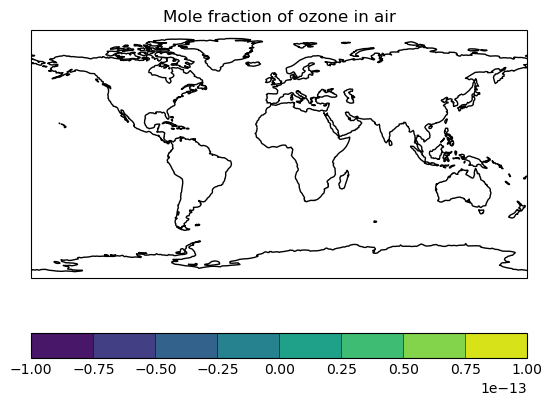

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


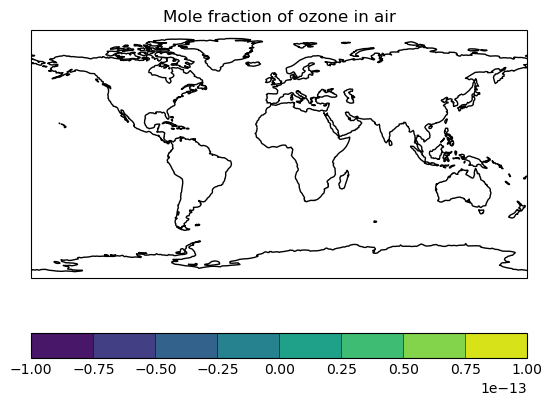

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


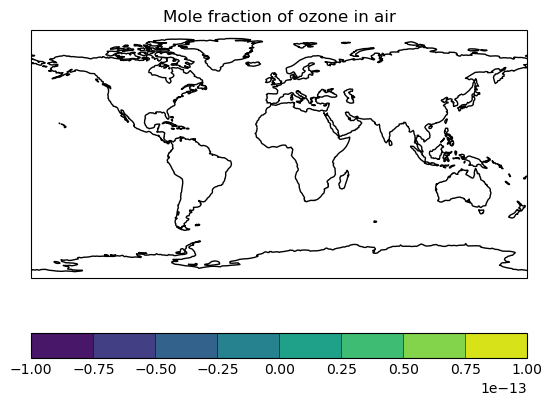

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


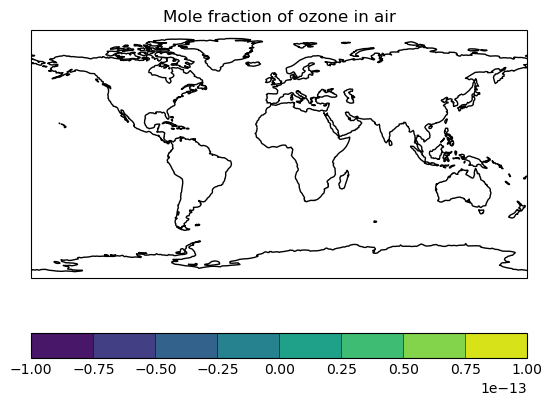

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


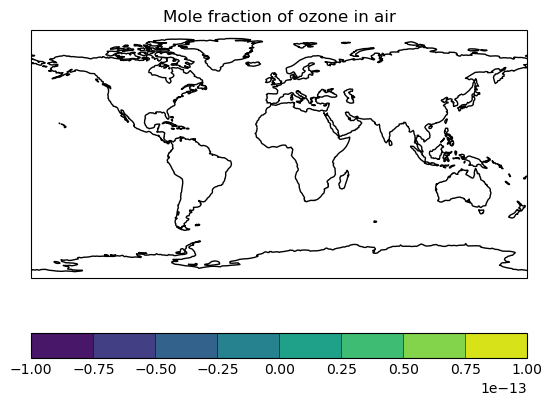

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


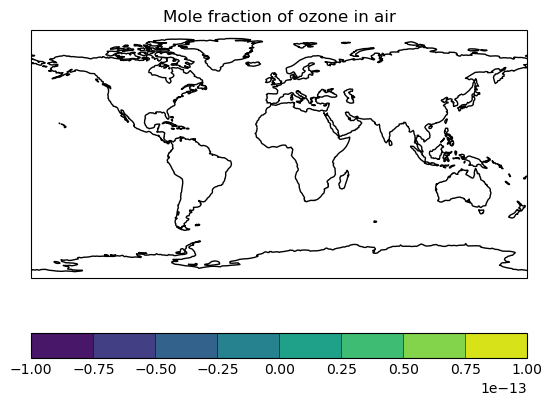

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


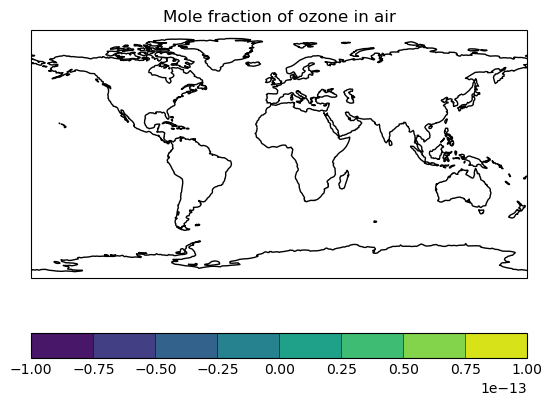

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


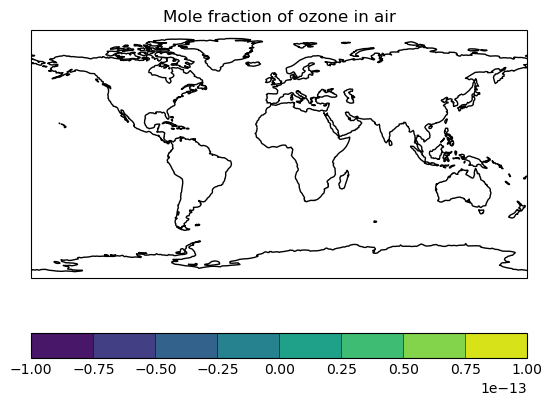

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


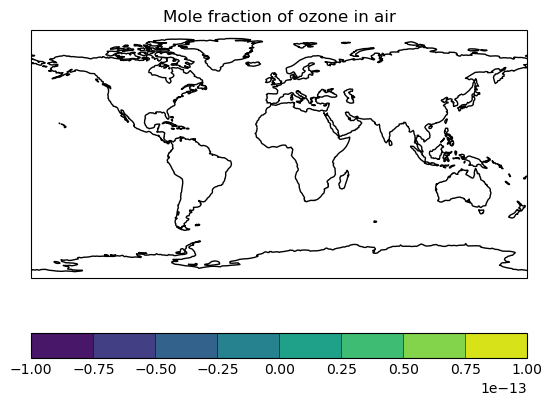

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


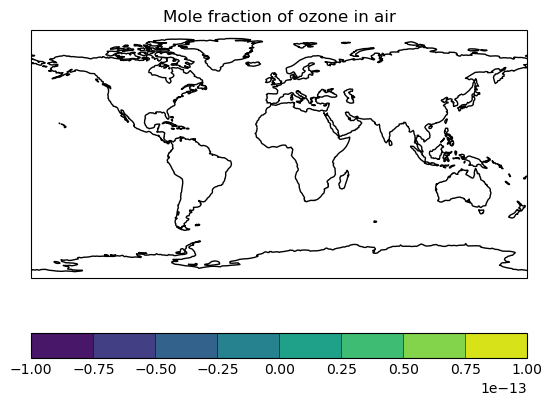

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


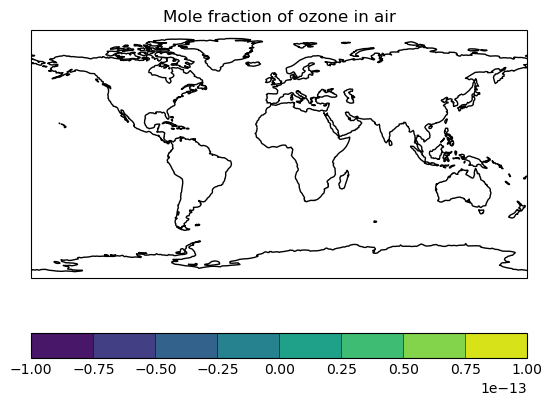

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


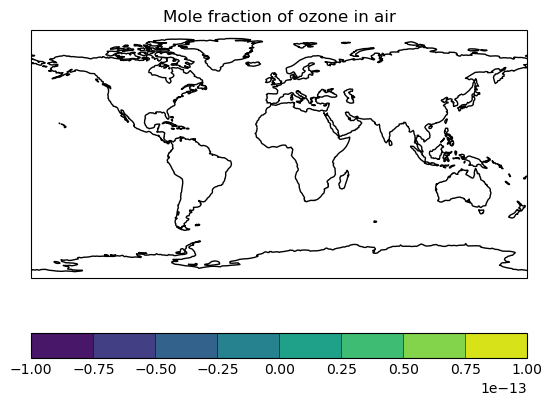

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


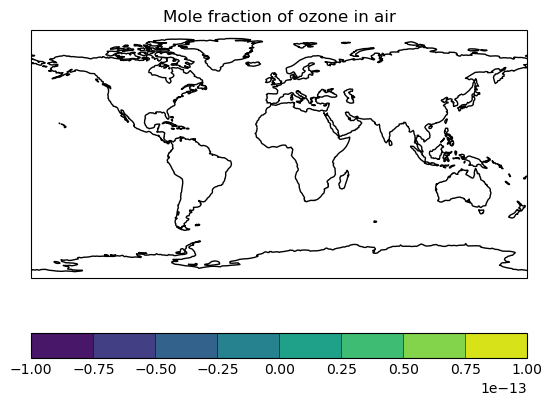

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


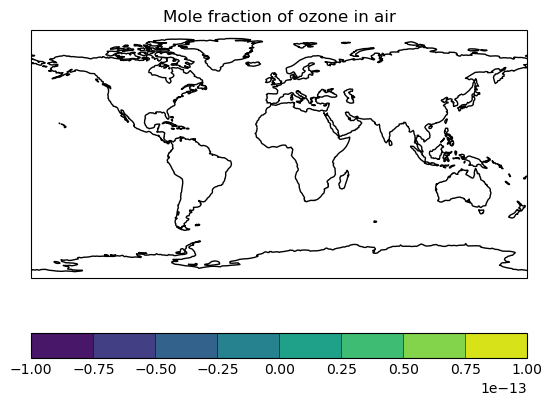

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


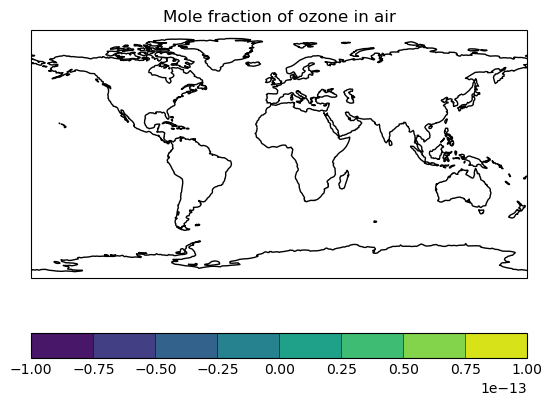

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


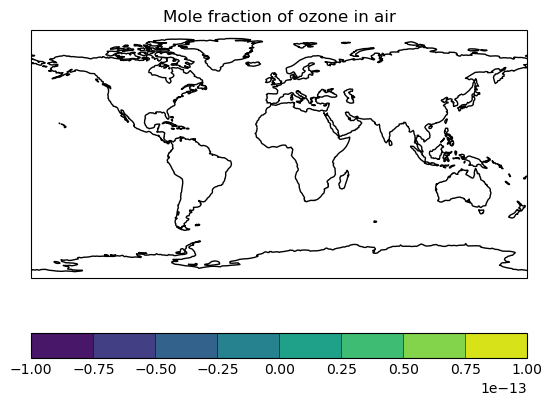

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


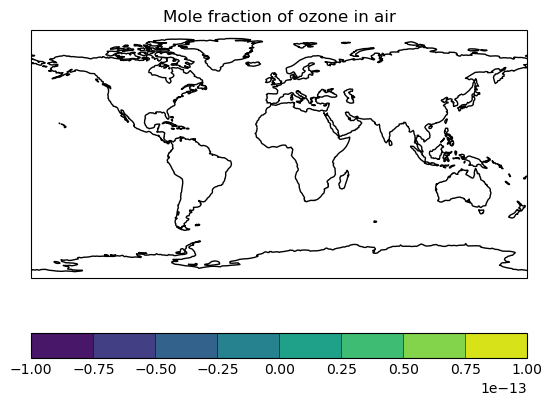

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


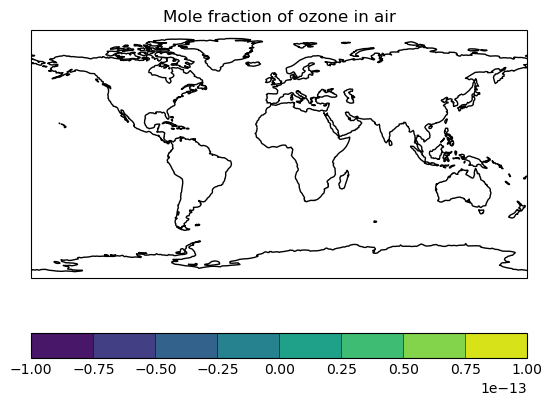

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


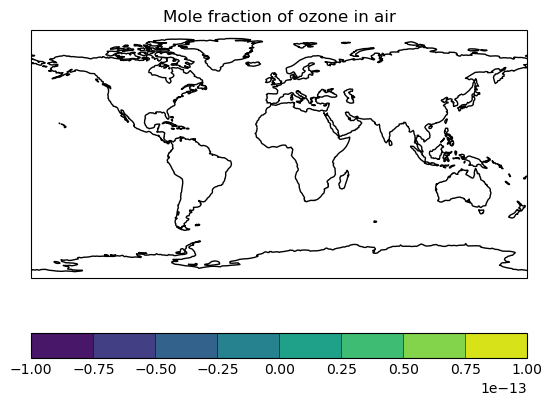

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


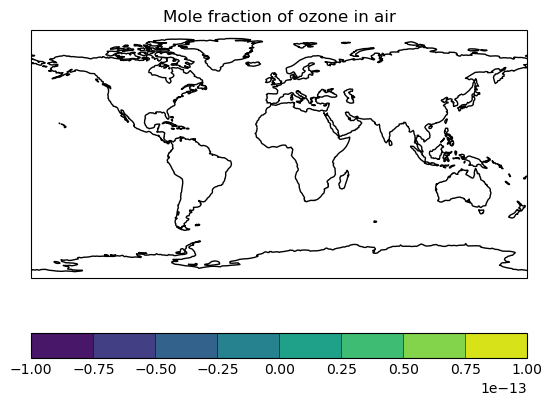

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


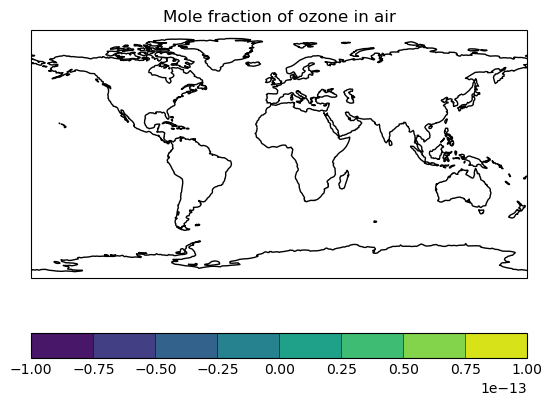

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


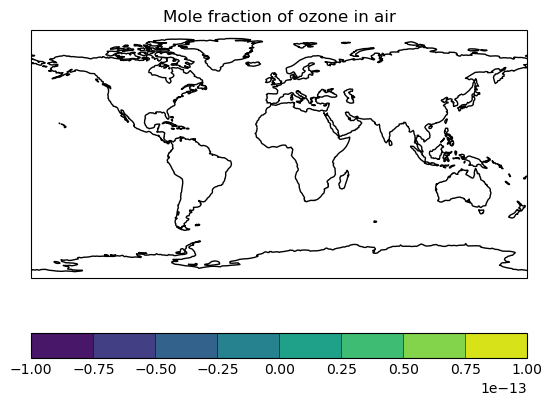

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


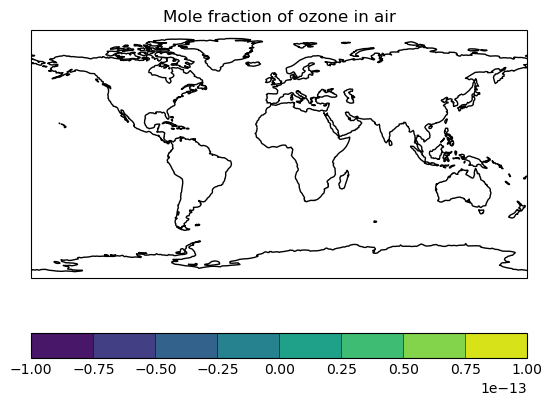

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


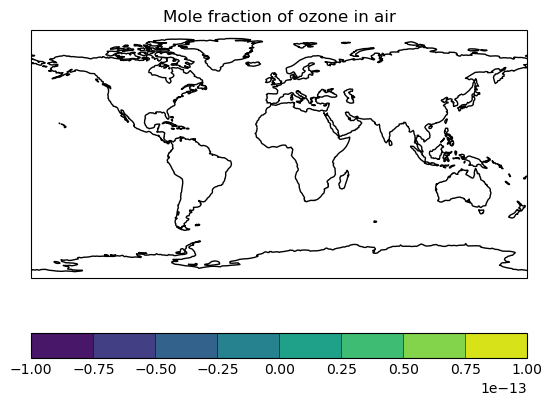

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


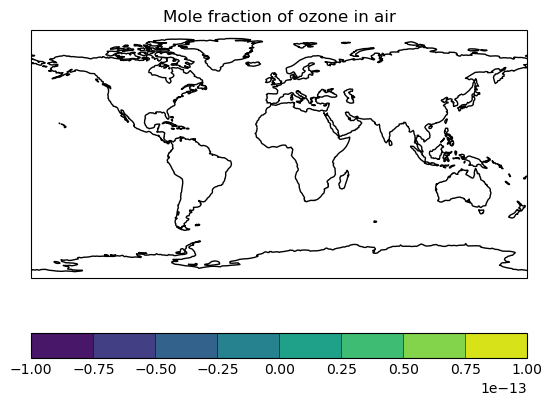

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


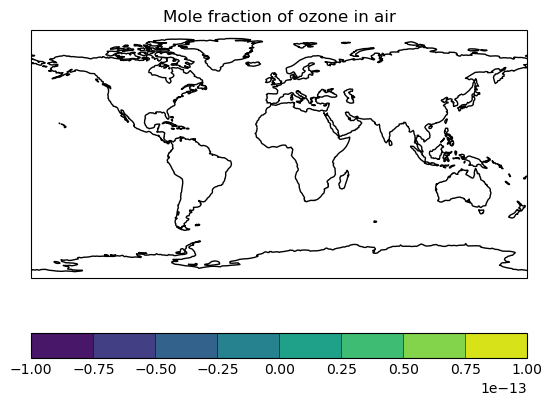

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


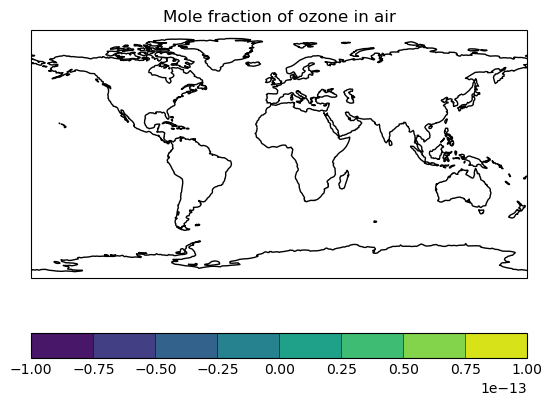

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


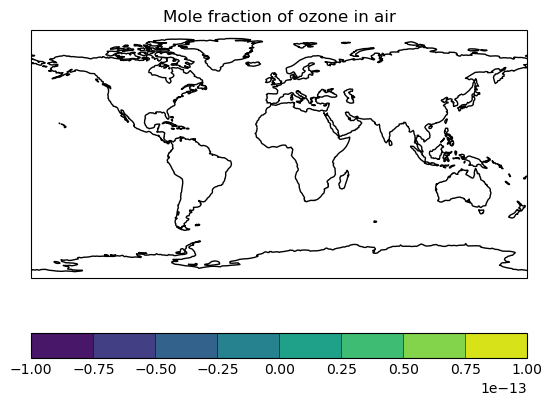

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


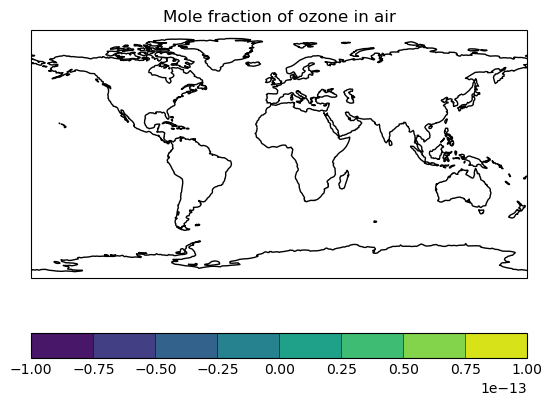

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


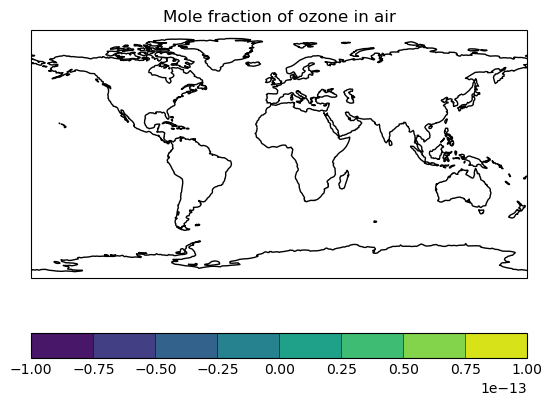

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


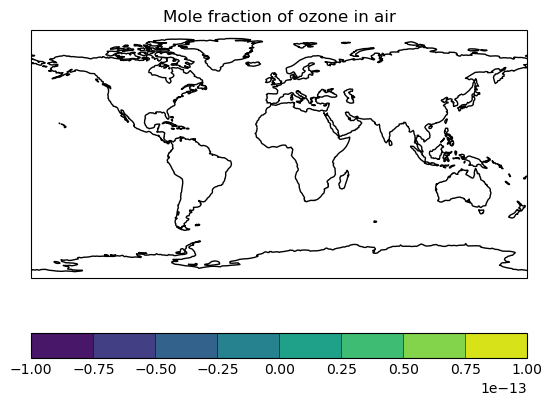

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


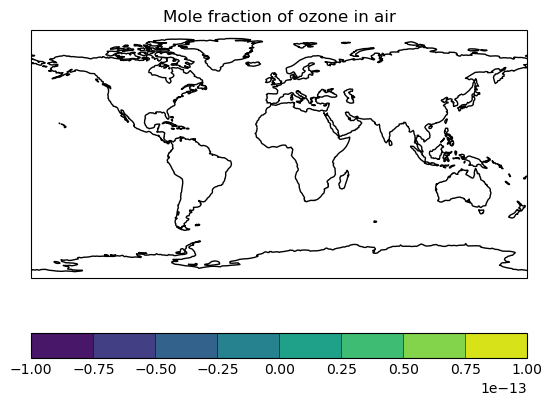

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


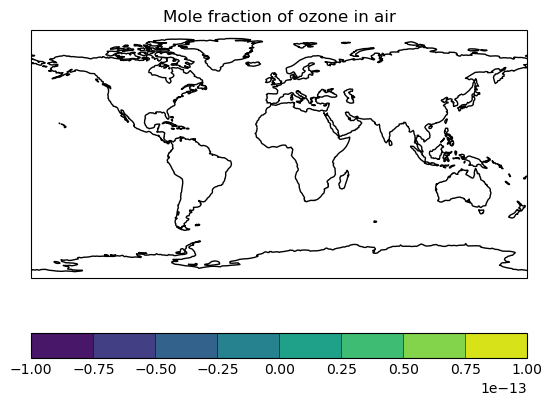

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


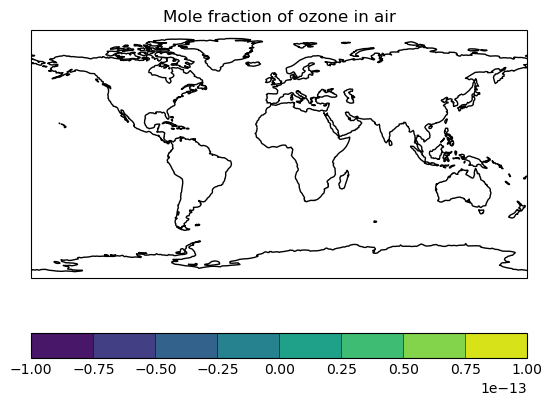

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


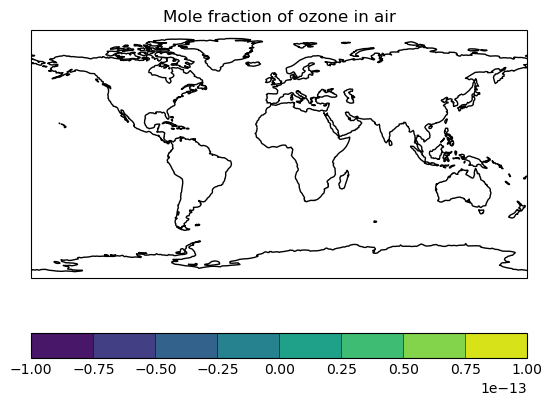

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/plot.py:1164: RuntimeWarning: All-NaN axis encountered
  if len(levels) > 0 and np.nanmax(cube.data) > levels[0]:


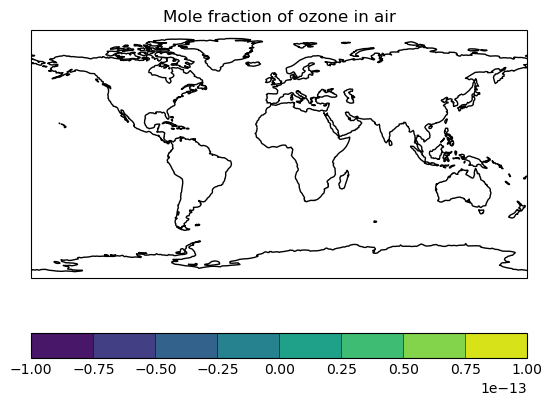

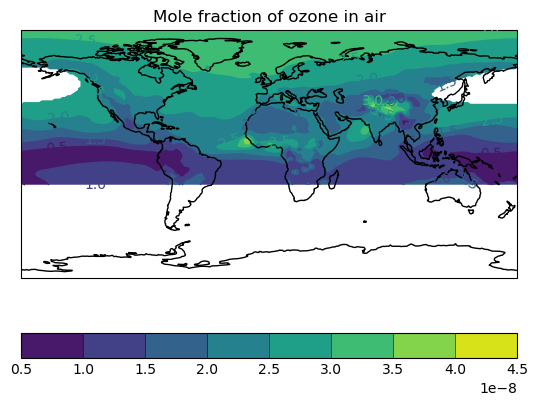

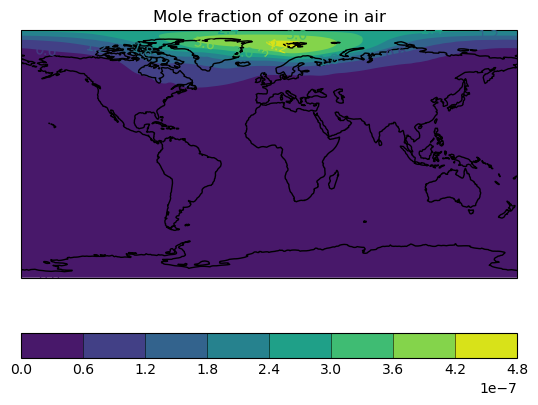

In [172]:
for n in range(38):
    # Add a filled contour, and put the result in a variable called contour.
    contour = qplt.contourf(cube_at_level(n+1))

    # Add coastlines to the map created by contour.
    plt.gca().coastlines()
    
    # Add contour labels based on the contour we have just created.
    plt.clabel(contour, inline=False)

    plt.show()